In [1]:
import jax.numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
main_path = "/var/home/luka/proj/Papilonidae_dataset_v2"
metadata = pd.read_csv(main_path+"/Papilonidae_metadata.txt", sep=",")
landmarks = pd.read_csv(main_path+"/Papilionidae_landmarks.txt", sep="\t", header=None)
aligned = pd.read_csv(main_path+"/Papilionidae_aligned.txt", sep="\t", header=None)

In [3]:
def convert_to_slice(df_subgroup):
    x_coords = df_subgroup[df_subgroup.iloc[:, 1] == "x-coordinates"].iloc[:, 2:].values
    y_coords = -df_subgroup[df_subgroup.iloc[:, 1] == "y-coordinates"].iloc[:, 2:].values
    return np.column_stack((x_coords.ravel(), y_coords.ravel()))

# Split dataframe by "Name" and convert each subgroup back to a 2D slice
def stack_slices(df_group):
    groups = [group for _, group in df_group.groupby(df_group.iloc[:, 0])]
    list_of_2d_slices = [convert_to_slice(group) for group in groups]
    return np.dstack(list_of_2d_slices)

In [4]:
def plot_wings_old(marks, sp=plt):
    s = 50
    for n in [0,s]:
        xs = marks[n:s+n, 0]
        ys = -marks[n:s+n, 1]
        sp.plot(xs, ys)
    sp.axis("equal")

In [5]:
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf"
]

def plot_wings(marks, sp=plt, cs=colors[:2], leg=None):
    s = 50
    for i in range(2):
        n = [0,s][i]
        c = cs[i]
        xs = marks[n:s+n, 0]
        ys = -marks[n:s+n, 1]
        if leg and not i:
            sp.plot(xs, ys,color=c,label=leg)
        else:
            sp.plot(xs, ys,color=c)
    sp.axis("equal")

    if leg:
        sp.legend()

In [6]:
data = stack_slices(aligned)
(h,t,N) = data.shape
assert h == 100 and t == 2
data_flat = np.reshape(data,(200,N))

In [7]:
def flat(marks):
    dims = len(marks.shape)
    if dims == 2:
        print("called flat() on 2d array, nothing happened.")
        return marks.reshape(marks.shape[0]*marks.shape[1])
    elif dims == 3:
        return marks.reshape(marks.shape[0]*marks.shape[1], marks.shape[2])
    else:
        raise ValueError("Invalid number of dimensions")

def unflat(marks, d=2):
    dims = len(marks.shape)
    if dims == 1:
        return marks.reshape(marks.shape[0]//d, d)
    elif dims == 2:
        return marks.reshape(marks.shape[0]//d, d, marks.shape[1])
    else:
        raise ValueError("Invalid number of dimensions")



In [8]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * np.where(x > 0, x, alpha * np.exp(x) - alpha)

x = np.arange(5.0)
print(selu(x))

[0.   1.05 2.1  3.15 4.2 ]


In [9]:
ser = (metadata.iloc[:,2]).astype("category")
ser = ser.cat.reorder_categories(
    ser[~ser.duplicated()].tolist(),  # Get categories by first appearance
    ordered=True  # Makes it an ordered Categorical
)
#print(ser)

In [10]:
names = []
species_data = []

# Iterate over each unique species
for spc in ser.cat.categories:
    print(spc)
    names.append(spc)
    # Get the indices corresponding to the current species
    indices = ser[ser == spc].index.tolist()
    # Extract the corresponding slices from axis 2 of `data`
    #spc_data = data_normalized[:, :, indices]
    spc_data = data[:, :, indices]
    # Append the numpy array to the result list
    species_data.append(spc_data)


Battus_polydamas
Papilio_aristodemus
Parides_photinus
Papilio_thoas
Papilio_polytes
Teinopalpus_imperialis
Graphium_agamemnon
Papilio_glaucus
Papilio_cresphontes
Papilio_deiphobus
Parides_agavus
Papilio_polyxenes
Papilio_protenor
Parides_eurimedes
Papilio_troilus
Papilio_zelicaon
Papilio_xuthus
Papilio_ambrax
Cressida_cressida
Pachliopta_kotzebuea
Baronia_brevicornis
Parnassius_orleans
Sericinus_montela
Battus_belus
Protographium_marcellus
Luehdorfia_puziloi
Byasa_alcinous
Trogonoptera_brookiana
Ornithoptera_richmondia
Troides_rhadamantus
Papilio_gigon
Pharmacophagus_antenor
Graphium_sarpedon
Zerynthia_polyxena
Atrophaneura_dixoni
Pachliopta_aristolochiae
Graphium_evemon
Losaria_coon
Allancastria_cerisyi
Euryades_corethrus
Iphiclides_podalirius
Meandrusa_sciron
Parnassius_honrathi
Atrophaneura_semperi
Papilio_slateri
Archon_apollinus
Papilio_phestus
Hypermnestra_helios


In [11]:
from math import sin, cos, atan

# rotates 2d landmarks theta radians around origin
def rotate(marks,th):
    R = np.array([[cos(th), -sin(th)], [sin(th), cos(th)]])
    return np.dot(marks, R)

# removes translational and rotational components from 2D landmarks
def proscutes_normalize(marks):
    # translate data so origin is mean

    (n,d) = marks.shape
    assert d == 2, "invalid marks shape"

    mean = np.mean(marks, axis=0)
    t = marks - mean

    # mean of each wing
    (a1,b1) = np.mean(t[50:],axis=0)
    (a2,b2) = np.mean(t[:50],axis=0)

    # average angle from wing mean to origin
    th1 = atan(b1/a1)
    th2 = atan(b2/a2)
    th = (th1 + th2) / 2

    # rotate data so wings are horizontally aligned
    # (that is, angle from wing mean to origin is approx. zero)
    return rotate(t, th)


Battus_polydamas______________118_______0.0000 
Papilio_aristodemus___________22________0.0001 !
Parides_photinus______________8_________0.0000 
Papilio_thoas_________________36________0.0001 
Papilio_polytes_______________137_______0.0000 
Teinopalpus_imperialis________7_________0.0005 !
Graphium_agamemnon____________290_______0.0000 
Papilio_glaucus_______________63________0.0001 
Papilio_cresphontes___________40________0.0001 !
Papilio_deiphobus_____________29________0.0000 
Parides_agavus________________6_________0.0001 !
Papilio_polyxenes_____________189_______0.0000 
Papilio_protenor______________24________0.0001 
Parides_eurimedes_____________54________0.0000 
Papilio_troilus_______________68________0.0000 
Papilio_zelicaon______________61________0.0000 
Papilio_xuthus________________41________0.0001 !
Papilio_ambrax________________54________0.0001 
Cressida_cressida_____________69________0.0001 
Pachliopta_kotzebuea__________33________0.0000 
Baronia_brevicornis___________4____

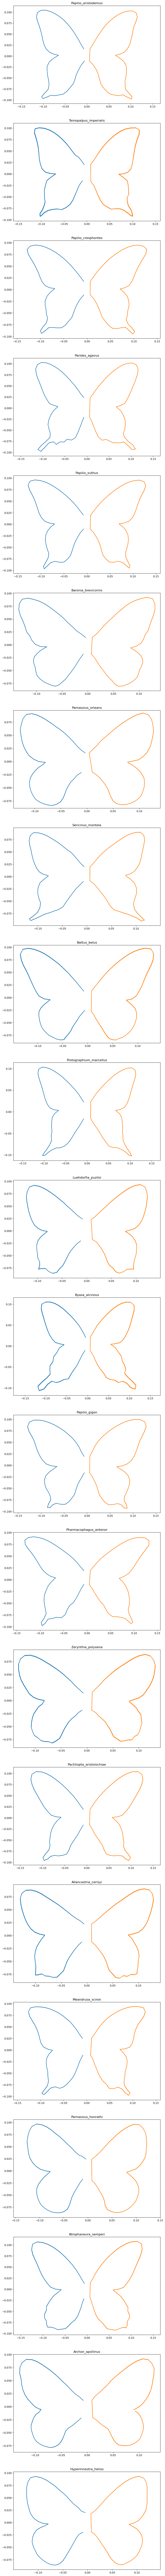

In [12]:
N = len(names)
Xa = np.empty((200,N))
Xb = np.empty((200,N))

plt.figure(figsize=(10, 8*N))
j = 1
b = " "
for i in range(N):
    s = species_data[i]
    (h,t,n) = s.shape
    assert h == 100 and t == 2, "invalid dimensions"


    xi = np.mean(s,axis=2)
    xi_pn = proscutes_normalize(xi)

    dif = np.mean(abs(xi_pn - xi))

    if dif > 1e-4:

        sp = plt.subplot(N,1,j)
        plt.title(names[i])
        plot_wings(xi,sp)
        plot_wings(xi_pn,sp)
        j += 1
        b = " !"


    Xa[:,i] = xi.ravel()
    Xb[:,i] = xi_pn.ravel()
    print(f'{names[i]:_<30}{n:_<10}{dif:4.4f}{b:s}')
    b = " "


plt.show()


In [13]:
from ete3 import Tree
ptree = Tree(main_path+"/papilionidae_tree.txt",format=1)
root = ptree.name
#print(ptree)

In [14]:
X = Xa.T
X.shape

(48, 200)

In [15]:
(N,d)   = X.shape
D       = np.empty((N*d,d))

for i in range(N*d):
    for j in range(d):
        if (j-1)*N < i >= j*N:
            D[i,j] = 1.


In [16]:
def ecov(a,b):
    na,nb = names[a],names[b]
    if a == b:
        mrca = ptree.search_nodes(name=names[a])[0]
    else:
        mrca = ptree.get_common_ancestor(na,nb)

    dist = ptree.get_distance(mrca)
    #print(f'{na:>30}\t{nb:>30}\t{mrca.name:>30}\t{dist}\n')

    return dist

evoCov = np.empty((N,N))

for i in range(N):
    for j in range(N):
        evoCov[i,j] = ecov(i,j)



In [17]:
v1 = np.ones(N)
evoCov_inv = np.linalg.inv(evoCov)
tmp = v1.T @ evoCov_inv
mle_r = ((tmp @ v1) **-1) * (tmp @ X)
assert mle_r.shape==(d,)

tmp = X - mle_r.T
mle_R = (((N - 1) ** -1) * tmp.T) @ evoCov_inv @ tmp
assert mle_R.shape==(d,d)

In [18]:
X_mean = np.mean(X,axis=0)
evoEvals, evoEvecs = np.linalg.eigh(evoCov)
X_cent = X - X_mean[None,:]

def ppca_recon(k=2):
    V_k = evoEvecs[:, -k:]
    #print(X_cent.shape,V_k.shape)
    X_reduced = X_cent.T @ V_k
    #print(X_reduced.shape)
    X_reconstructed = X_reduced @ V_k.T + X_mean[:,None]
    return unflat(X_reconstructed)

In [19]:
X.shape

(48, 200)

runtime modul

In [20]:
for k in range(1,N+1):
    ppca_recon(k)